#IMAGE CAPTIONING USING DEEP LEARNING
**2303A52065 Ayesha Ahmed Ilyas,** **2303A52073 S. Yagneshwar,** **2303A52429 V. Vyshnavi,** **2303A52485 M. Jayanth** *(Batch 32)*

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
import kagglehub
adityajn105_flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

In [3]:
images_directory = '/kaggle/input/flickr8k/Images/'
captions_path = '/kaggle/input/flickr8k/captions.txt'

In [5]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions
def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer
captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

In [7]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [9]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

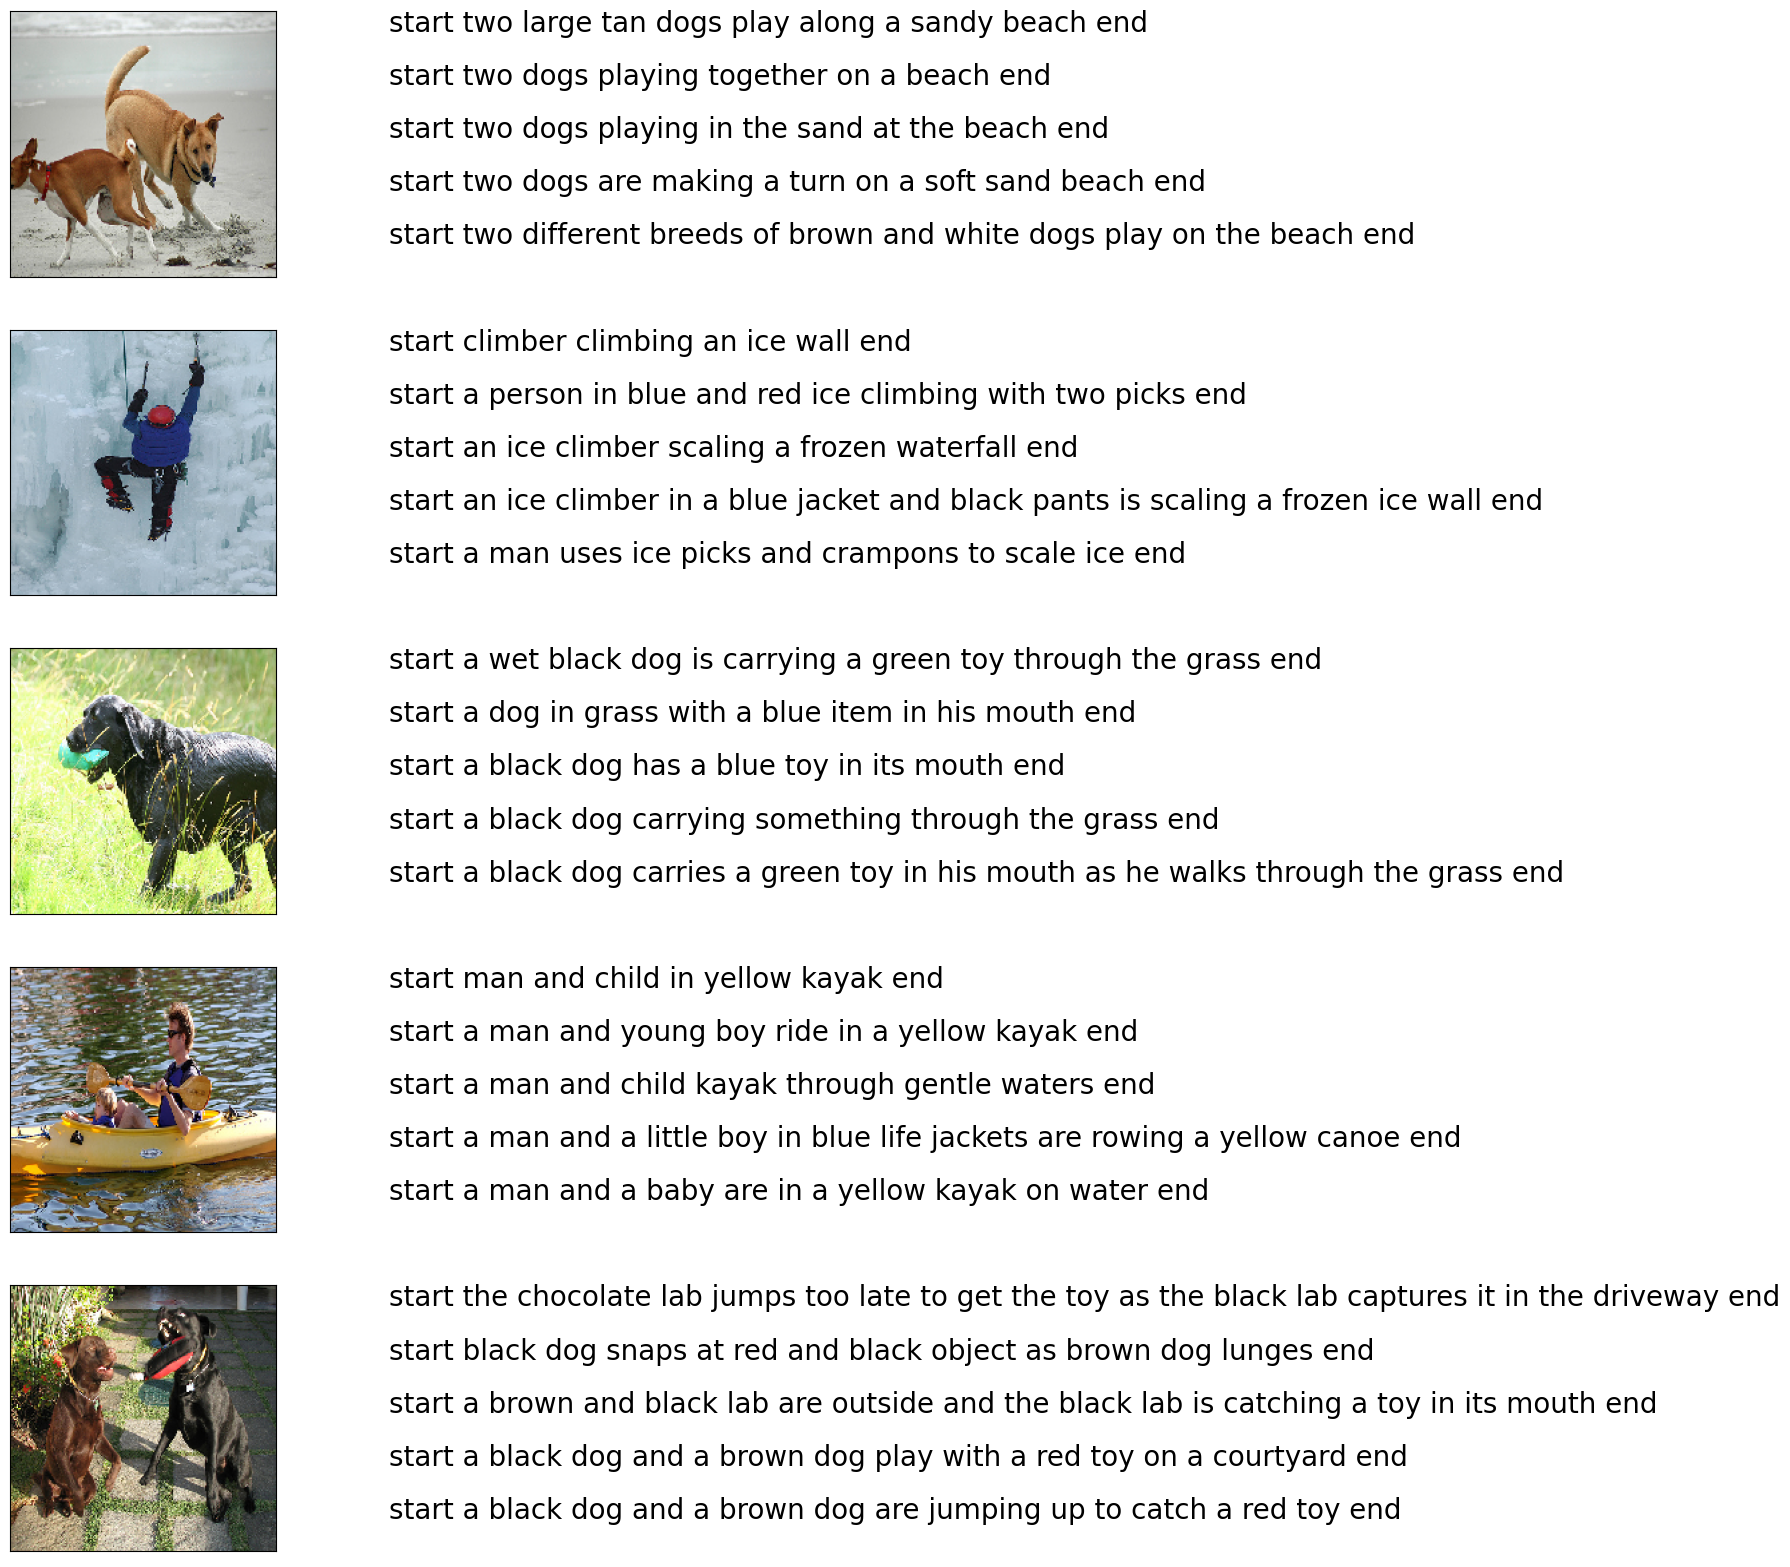

In [10]:
def visualaization(data, num_of_images):
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1
        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
visualaization(captions_IDs, 5)

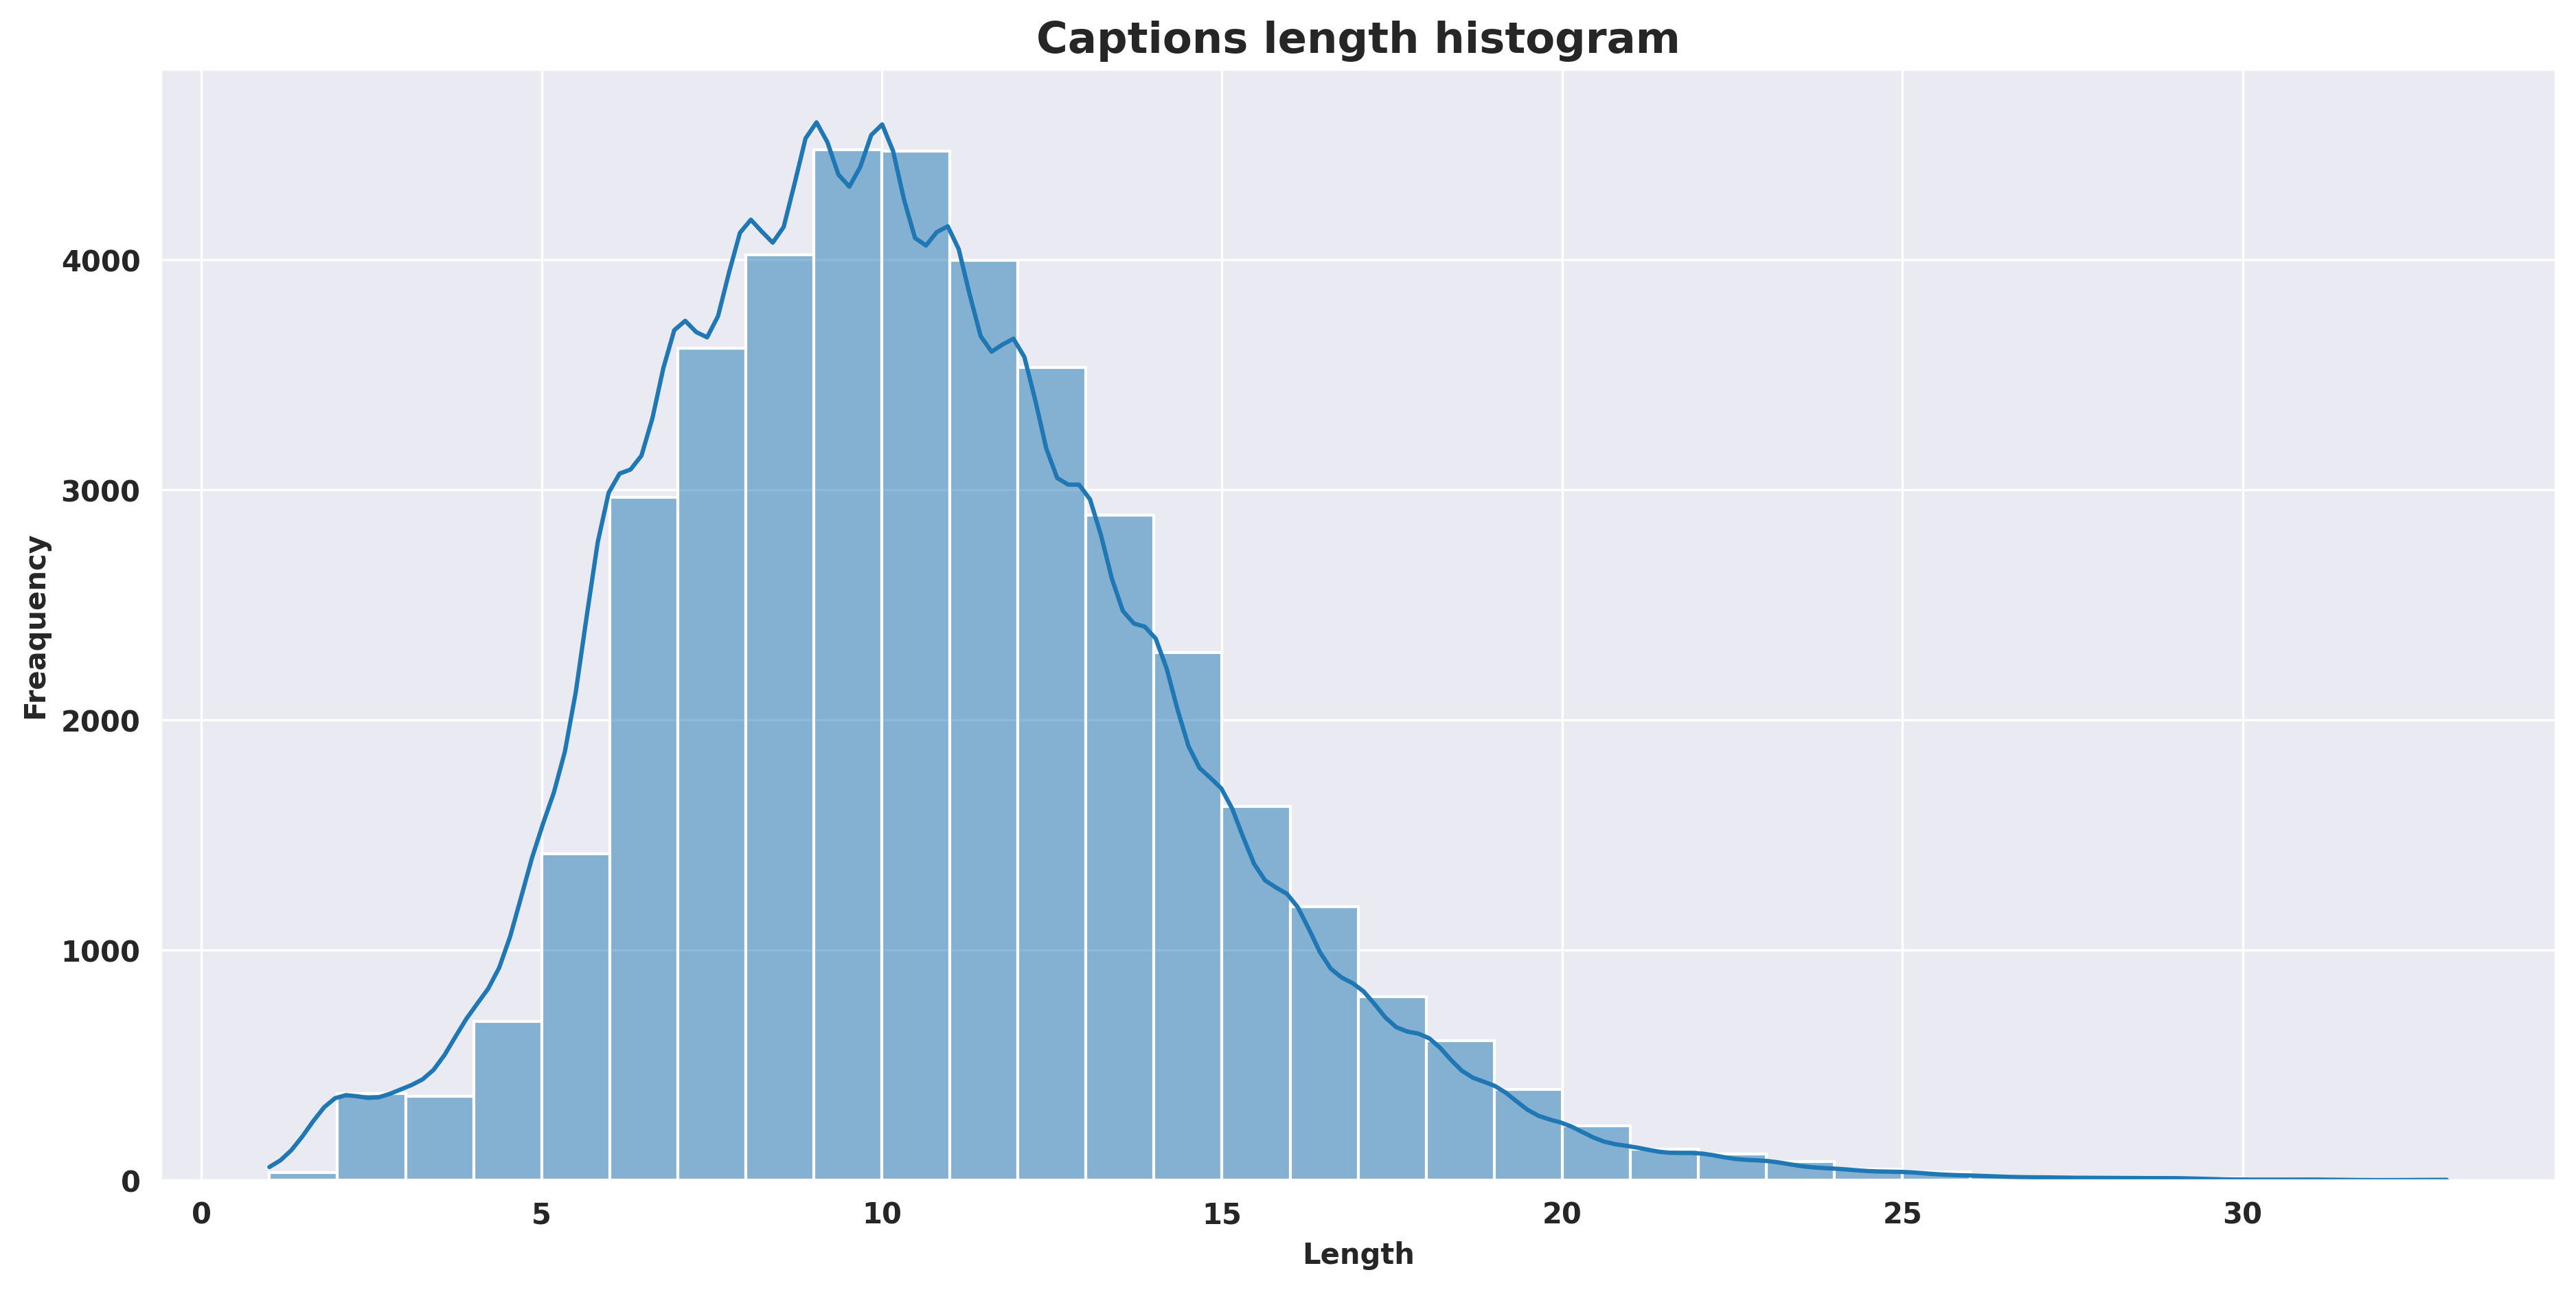

In [11]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
captions_length(cleaned_captions)

In [58]:
def word_occurrences(data):
    all_text = ' '.join(data)
    word_counts = Counter(all_text.split())
    words = list(word_counts.keys())[1:30]
    values = list(word_counts.values())[1:30]
    normalized_values = np.array(values) / np.max(values)
    colors = np.array(['rgba(30, 58, 138, {})'.format(0.4 + 0.5 * (value)) for value in normalized_values])
    fig = go.Figure(data=[go.Pie(labels=words, values=values, hole=.6, marker=dict(colors=colors), textinfo='label')])
    fig.update_layout(title_text='Word occurrences in captions (except for letter \'a\')', title_font=dict(size=23, family='Balto'))
    fig.show()
word_occurrences(cleaned_captions)

In [15]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

In [16]:
all_image_ids = os.listdir(images_directory)
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)
train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')
    if image_id in train_image_ids:
        train_captions.append(caption)
    elif image_id in val_image_ids:
        val_captions.append(caption)
    elif image_id in test_image_ids:
        test_captions.append(caption)
    else:
        print('Unknown image ID !')
train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

In [17]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img
def get_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features
inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
train_image_features, val_image_features, test_image_features = {}, {}, {}
pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')
for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = get_image_features(inception_v3_model, image_path)
    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()
        pbar.update(1)
    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()
        pbar.update(1)
    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()
        pbar.update(1)
    else:
        print('Unknown image ID !')
pbar.close()

  0%|          | 0/8091 [00:00<?, ?it/s]

In [38]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)
            # Convert to TensorFlow tensors
            X_images = tf.convert_to_tensor(np.array(X_images))
            X_captions = tf.convert_to_tensor(np.array(X_captions))
            y = tf.convert_to_tensor(np.array(y))

            # Yielding a tuple of tensors, not a list of tensors
            yield ((X_images, X_captions), y) # Yielding tensors


max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1
cnn_output_dim = inception_v3_model.output_shape[1]
batch_size_train = 270
batch_size_val = 150
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

# Get a sample batch to infer shapes and dtypes
sample_batch_x, sample_batch_y = next(train_data_generator)

# Define output signature using tf.type_spec based on the sample batch
# Define output signature using tf.type_spec based on the sample batch
# The first element of the tuple is now a tuple of TypeSpecs, reflecting the structure of the yielded data
output_signature = (
    (tf.TensorSpec(shape=sample_batch_x[0].shape, dtype=sample_batch_x[0].dtype),  # X_images TypeSpec
     tf.TensorSpec(shape=sample_batch_x[1].shape, dtype=sample_batch_x[1].dtype)),  # X_captions TypeSpec
    tf.TensorSpec(shape=sample_batch_y.shape, dtype=sample_batch_y.dtype)  # y TypeSpec
)


# Apply output signature to the datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data_generator, output_signature=output_signature
)
val_dataset = tf.data.Dataset.from_generator(
    lambda: val_data_generator, output_signature=output_signature
)

In [39]:
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('=========================')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (3025, 2048)
X_captions: (3025, 34)
y: (3025, 8586)
Validation sample batch shapes:
X_images: (1676, 2048)
X_captions: (1676, 34)
y: (1676, 8586)


In [40]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = BatchNormalization()(fe2)
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)
optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
caption_model.summary()

Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Features_Input      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ Features_Input[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sequence_Input      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 34, 256)   │  2,198,016 │ Sequence_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 34)        │          0 │ Sequence_Input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    525,312 │ embedding_3[0][0… │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8586)      │  2,206,602 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
def lr_scheduler(epoch, lr):
    return lr * np.exp(-0.6)
lr_schedule = LearningRateScheduler(lr_scheduler)
history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 1347s 11s/step - loss: 2.4503 - val_loss: 3.2423 - learning_rate: 4.5166e-05
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 1329s 10s/step - loss: 2.4424 - val_loss: 3.2325 - learning_rate: 2.4788e-05
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 1339s 11s/step - loss: 2.4404 - val_loss: 3.2393 - learning_rate: 1.3604e-05
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 1343s 11s/step - loss: 2.4420 - val_loss: 3.2302 - learning_rate: 7.4659e-06
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 1342s 11s/step - loss: 2.4383 - val_loss: 3.2471 - learning_rate: 4.0973e-06
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 1311s 10s/step - loss: 2.4342 - val_loss: 3.2298 - learning_rate: 2.2487e-06
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 1305s 10s/step - loss: 2.4323 - val_loss: 3.2308 - learning_rate: 1.2341e-06
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 1342s 11s/step - loss: 2.4300 - val_loss: 3.2379 - learning_rate: 6.7729e-07
Epoch 9/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 1344s 11s/step - loss: 2

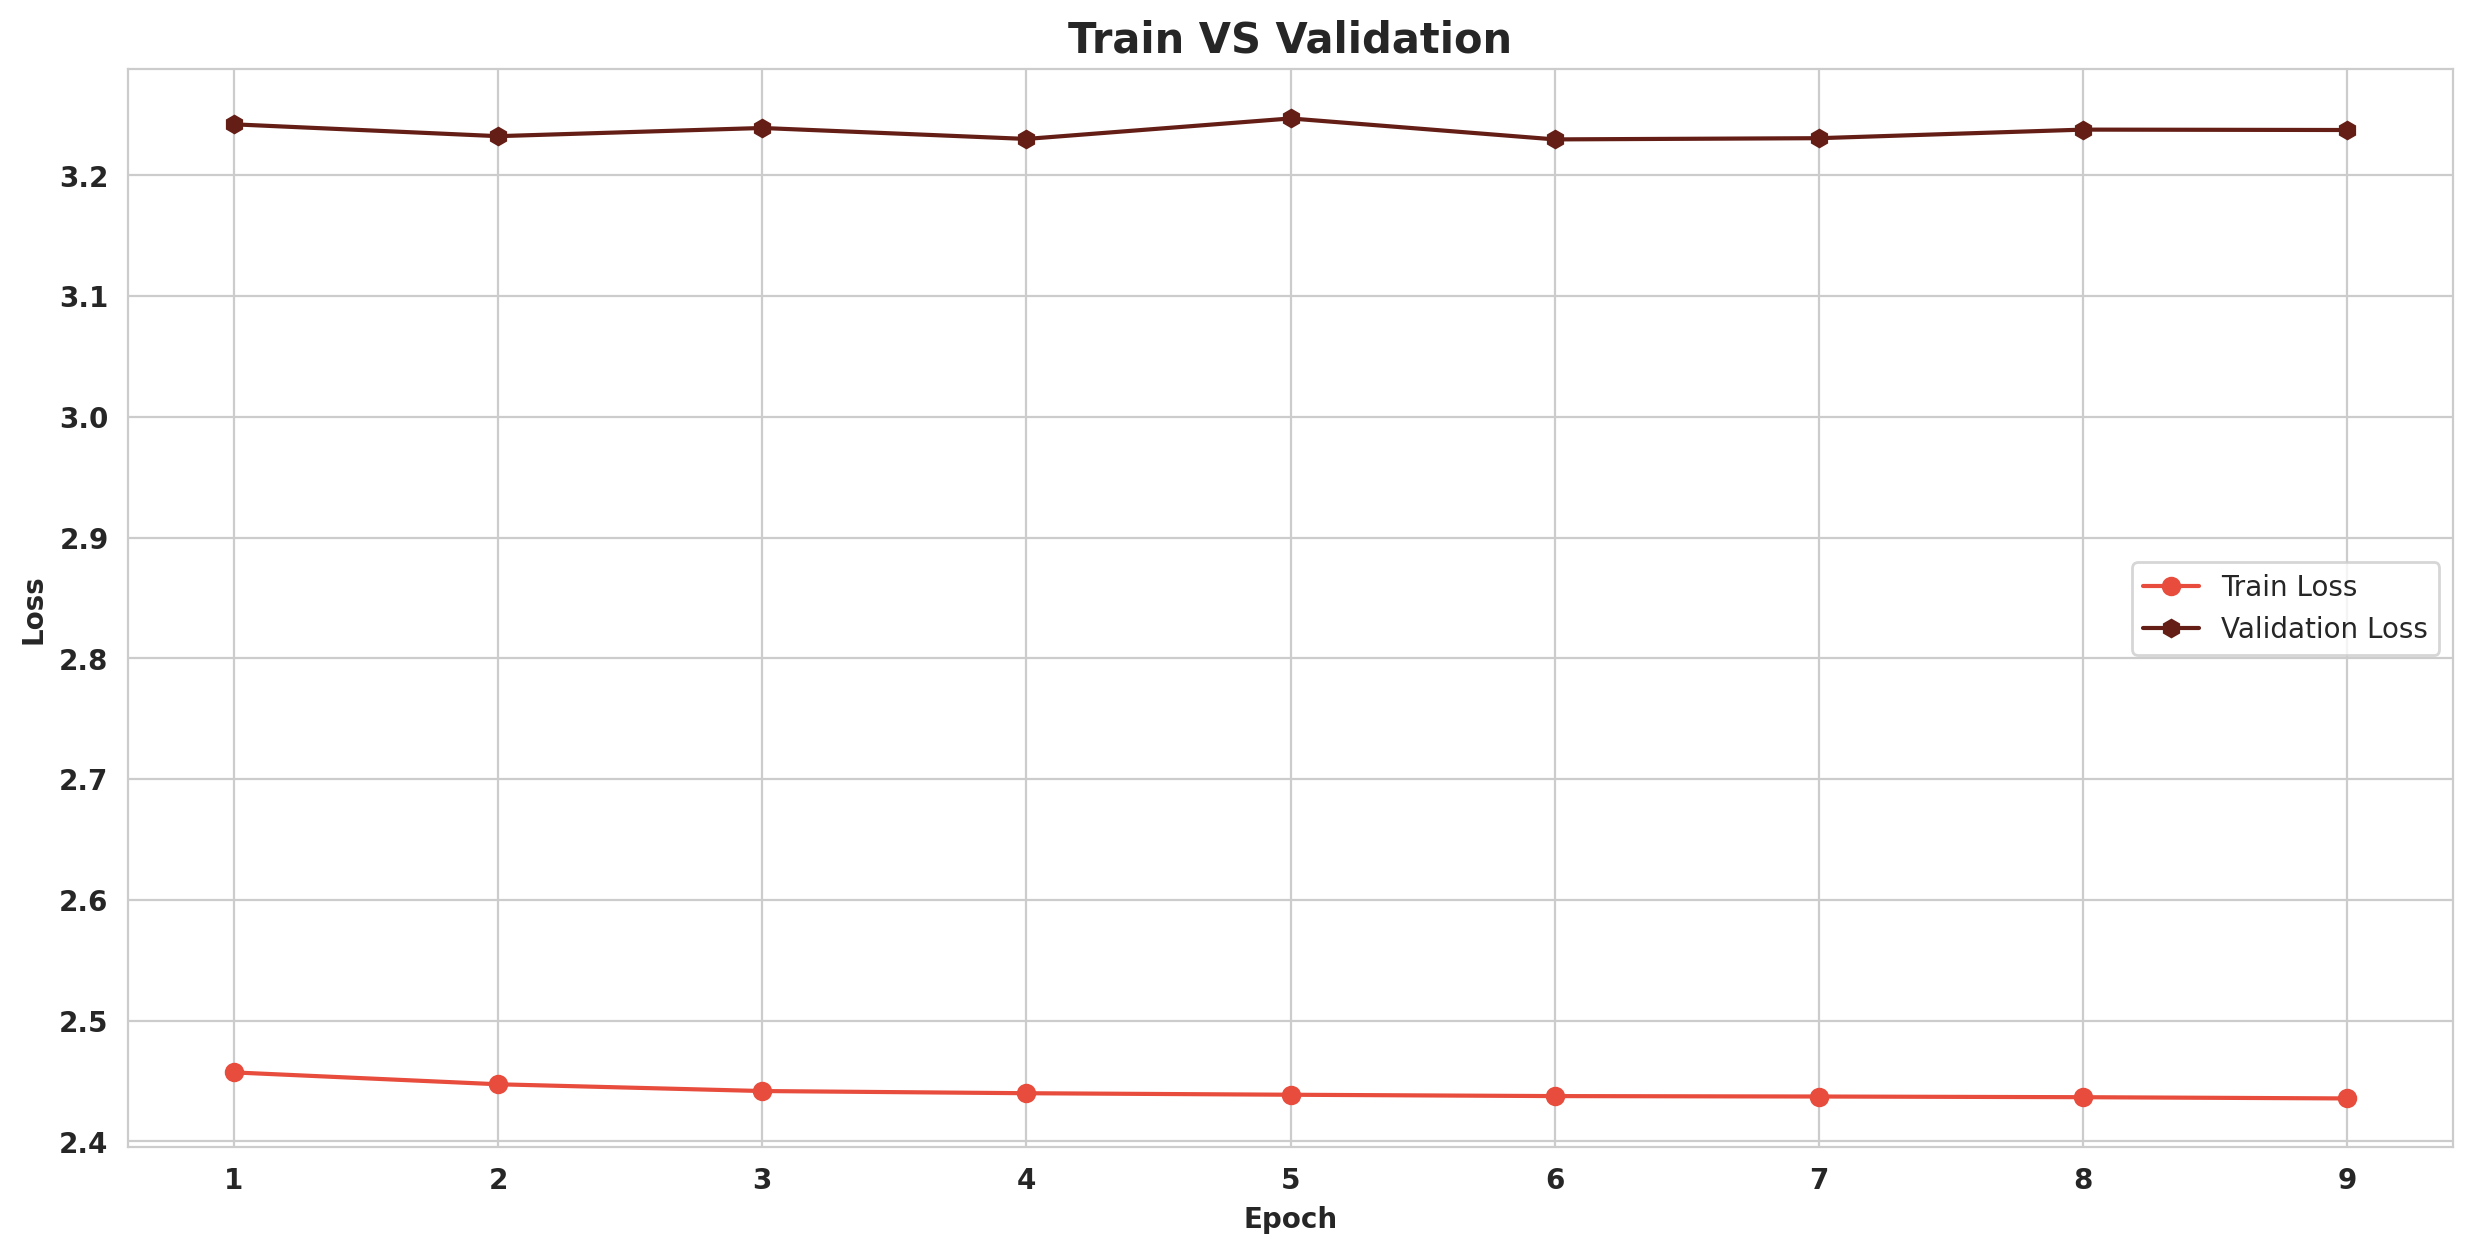

In [56]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [45]:
def greedy_generator(image_features):
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text

In [44]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1,max_caption_length))
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w])
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-K_beams:]
    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]
    final_caption = []
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [46]:
def BLEU_score(actual, greedy, beam_search):
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))
    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]

In [47]:
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [48]:
generated_captions = {}
pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)
pbar.close()

  0%|          | 0/122 [00:00<?, ?it/s]

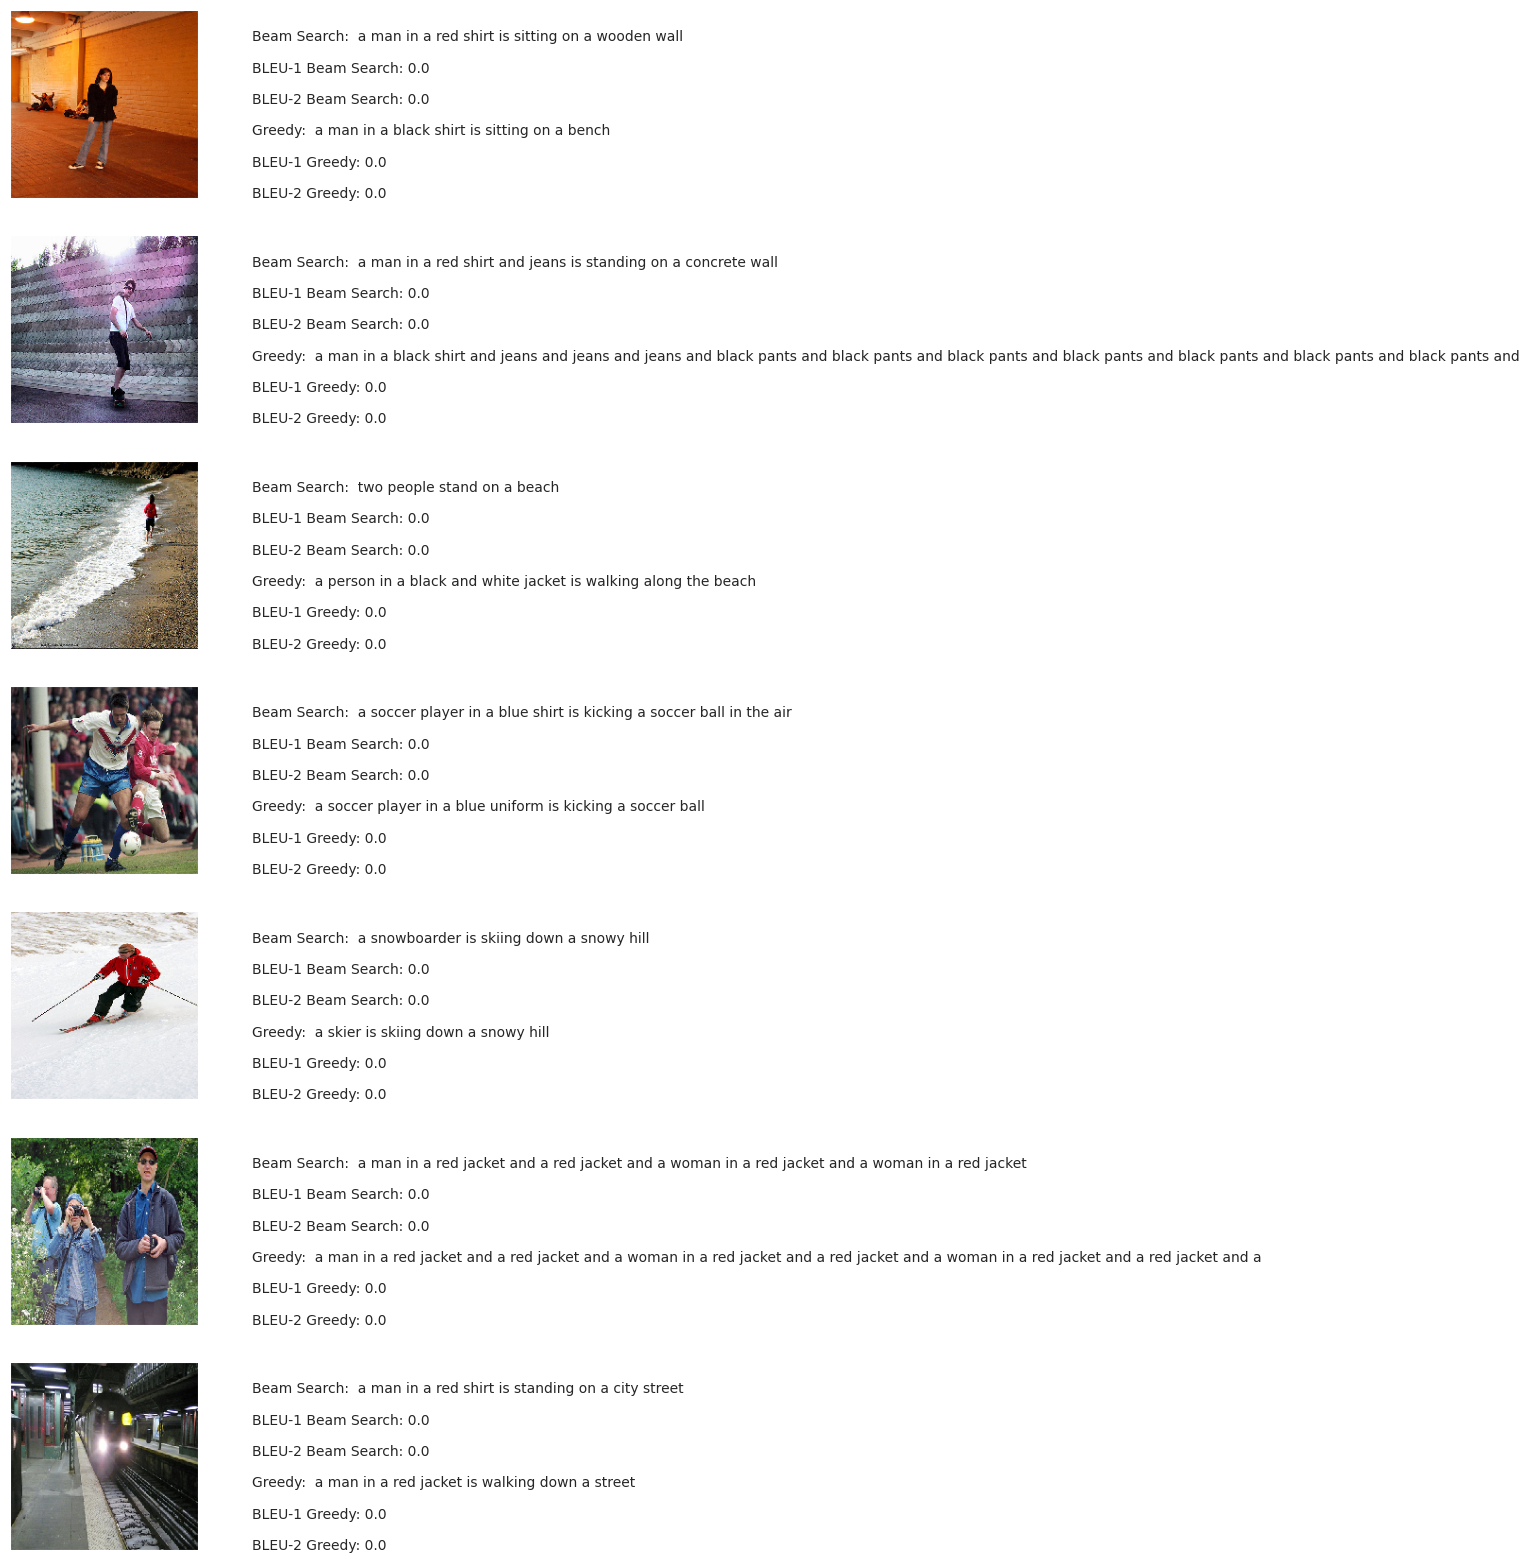

In [49]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys())
    images = [np.random.choice(keys) for i in range(num_of_images)]
    count = 1
    fig = plt.figure(figsize=(6,20))
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap]
        actual_cap = [x.replace(" end", "") for x in actual_cap]
        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])
        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)), [beamS_cap]*(len(actual_cap)))
        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1
        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()
visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)

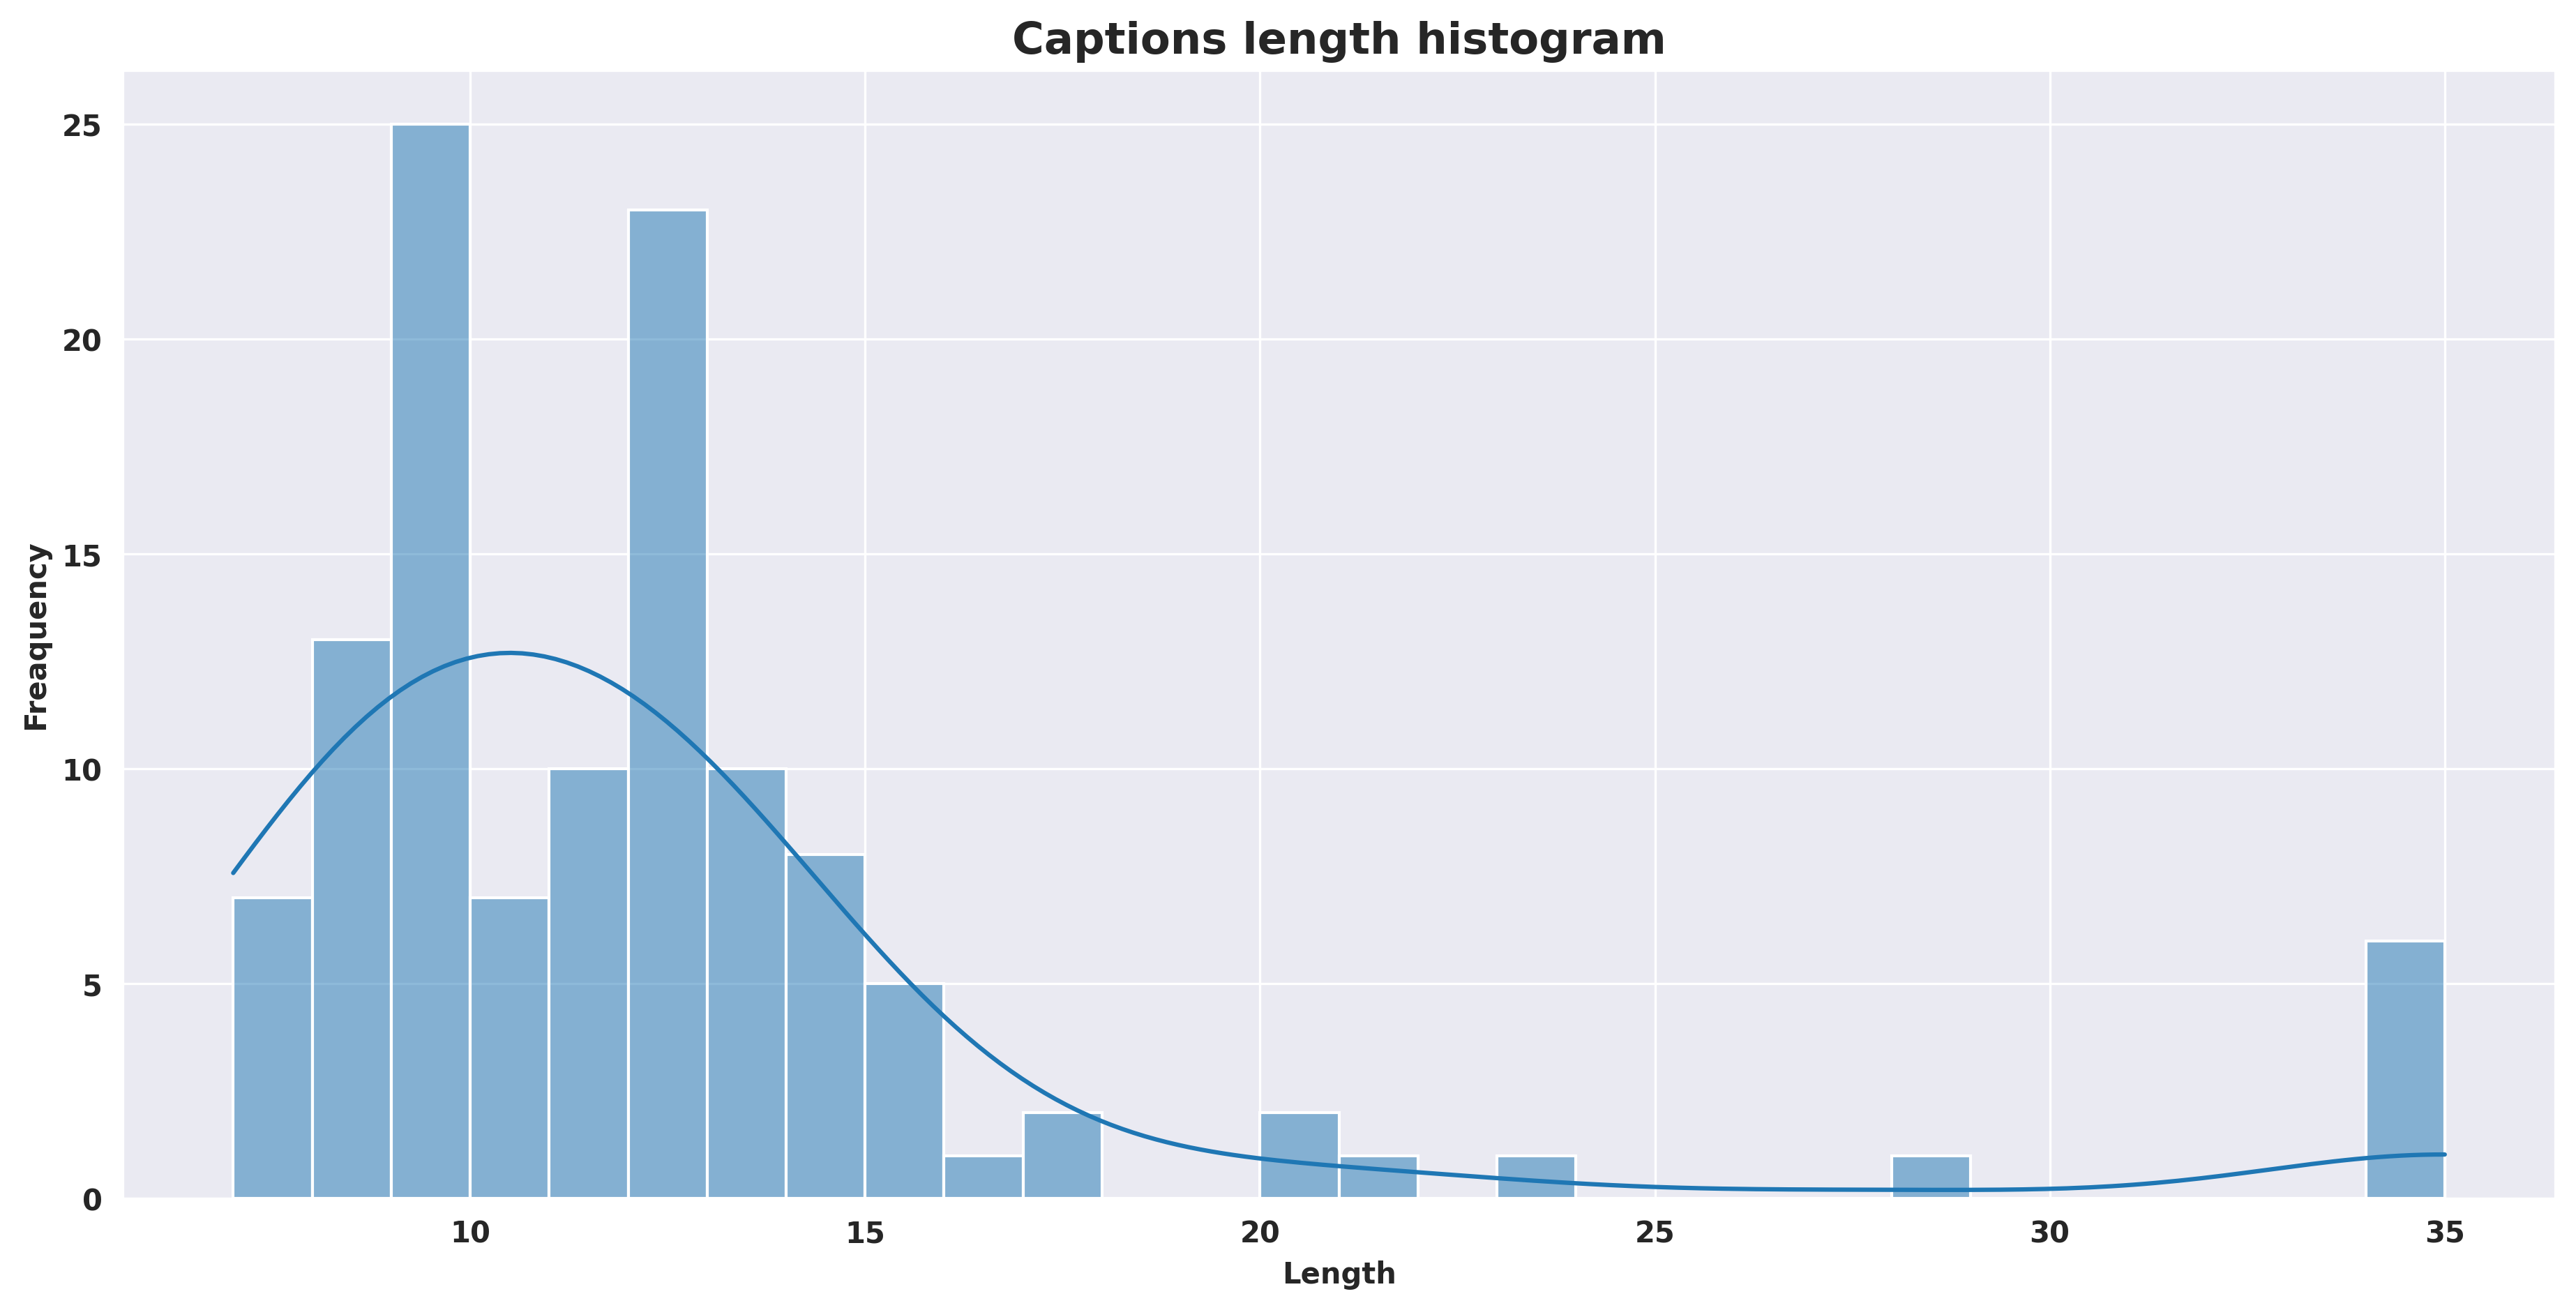

In [50]:
captions_length(list(generated_captions.values()))

In [51]:
word_occurrences(list(generated_captions.values()))

In [60]:
caption_model.save('image_captioning_model.keras')

In [64]:
from google.colab import drive
drive.mount('/content/drive')
caption_model.save("/content/drive/MyDrive/caption_model.h5")
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("max_length.txt", "w") as f:
    f.write(str(max_caption_length))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
